In [42]:
import numpy as np
from torchvision import transforms, datasets
from torchvision.io import read_image
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.model_selection import train_test_split
from MobileNetV2 import mobilenetv2_19

DATA_ROOT_PATH = "../data/"

In [43]:
class ContactDataSet(Dataset) :
    def __init__(
        self,
        data_root_path,
        image_paths,
        data_transforms
    ) :
        super(ContactDataSet, self).__init__()
        self.data_root_path = data_root_path
        self.image_paths = image_paths
        self.data_transforms = data_transforms

    def __len__(self) :
        return len(self.image_paths)

    def __getitem__(self, item) :
        image_path = self.image_paths[item]
        image = Image.open(os.path.join(
            self.data_root_path,
            image_path,
        ))
        label = image_path.split("_")[-1].split(".")[0]
        
        return (
            self.data_transforms(image),
            torch.Tensor(list(map(
                lambda chararc : int(chararc),
                label
            )))
        )

In [74]:
def makeTrainValidDataLoaders(
    data_root_path,
    val_ratio,
    batch_size
) :
    whole_dataset = ContactDataSet(
        data_root_path,
        list(filter(
            lambda image_path : "png" in image_path,
            os.listdir(DATA_ROOT_PATH)
        )),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            )
        ])
    )
    train_idx, val_idx = train_test_split(
        list(range(len(whole_dataset))), test_size = val_ratio
    )
    train_dataset = Subset(whole_dataset, train_idx)
    valid_dataset = Subset(whole_dataset, val_idx)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    return train_data_loader, valid_data_loader 

def makeTestDataLoaders(
    data_root_path,
    batch_size
) :
    test_dataset = ContactDataSet(
        data_root_path,
        list(filter(
            lambda image_path : "png" in image_path,
            os.listdir(DATA_ROOT_PATH)
        )),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            )
        ])
    )
    test_data_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=True
    )
    return test_data_loader 


In [75]:
train_data_loader, valid_data_loader = makeTrainValidDataLoaders(
    DATA_ROOT_PATH,
    0.2,
    400
)

In [46]:
for i, (features, labels) in enumerate(train_data_loader) :
    print(i, features.shape, labels.shape)

    if i > 3 :
        break

0 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
1 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
2 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
3 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
4 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])


In [33]:
for i, (features, labels) in enumerate(valid_data_loader) :
    print(i, features.shape, labels.shape)

0 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
1 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
2 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
3 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
4 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
5 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
6 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
7 torch.Size([400, 3, 224, 224]) torch.Size([400, 6])
8 torch.Size([196, 3, 224, 224]) torch.Size([196, 6])


In [106]:
model = mobilenetv2_19(num_classes = 6) 

In [76]:
images, labels = next(iter(train_data_loader))

In [107]:
outputs= model(images)

In [110]:
print(outputs.shape)
print(outputs[0])

torch.Size([400, 6])
tensor([ -38.4562,  114.4404, -177.1099, -130.4848,   98.4620, -123.7386],
       grad_fn=<SelectBackward0>)


In [123]:

def initialize_parameters(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        #torch.nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data, gain=torch.nn.init.calculate_gain('relu'))
        #torch.nn.init.constant_(m.bias.data, 0)

In [120]:
model = mobilenetv2_19(num_classes = 6)

In [124]:
model.apply(initialize_parameters)

MobileNetV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [125]:
outputs = model(inputs)

In [ ]:
print(outputs[:10])

In [77]:
to_pil_image = transforms.ToPILImage()

image = np.array(to_pil_image(images[0]))
image.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


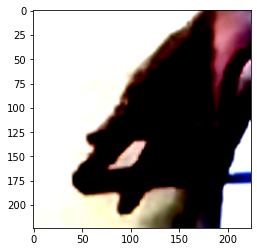

In [79]:
plt.imshow(images[0].numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


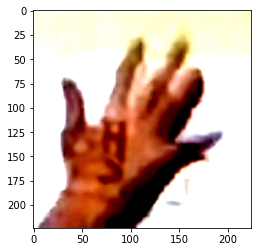

In [69]:
plt.imshow(images[0].numpy().transpose((1, 2, 0))